In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import category_encoders as ce
from pathlib import Path

In [2]:
np.random.seed(10)

# GETTING THE DATASET
Here I download the dataset (3/4 Mb, but pandas is a bit slow to download it), delete the rows with missing values and replace the targets with a 0 and 1 instead of '<=50K', '>50K'

In [3]:
DATASET_PATH = Path("./adult.data")
DATASET_URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data' if not DATASET_PATH.exists() else DATASET_PATH
columns = ['Age', 'Workclass', 'Fnlwgt', 'Education', 'Education-num', 'Marital-status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Capital-gain', 'Capital-loss', 'Hours-per-week', 'Native-country', 'Target']
df = pd.read_csv(DATASET_URL, names=columns, na_values=['?', ' ?', '? '])

In [4]:
# strip the strings
df_str = df.select_dtypes(['object'])
df[df_str.columns] = df_str.apply(lambda x: x.str.strip())
# remove missing values and duplicates
df = df.dropna()
df = df.drop_duplicates()
# map the target into {0,1}
map_targ = {
        '<=50K': 0,
        '>50K': 1
}

feat = df.iloc[:, :-1]
targ = df.iloc[:, -1]
targ = targ.map(map_targ)

targenc = ce.TargetEncoder(verbose=1,return_df=True)
df = targenc.fit_transform(feat, targ)
df['Target'] = targ

In [5]:
df

,Age,Workclass,Fnlwgt,Education,Education-num,Marital-status,Occupation,Relationship,Race,Sex,Capital-gain,Capital-loss,Hours-per-week,Native-country,Target
0,39,0.268960,77516,0.421658,13,0.048399,0.133907,0.106689,0.263855,0.313955,2174,0,40,0.254411,0
1,50,0.285829,83311,0.421658,13,0.455011,0.485342,0.455728,0.263855,0.313955,0,0,13,0.254411,0
2,38,0.218918,215646,0.164328,9,0.107312,0.061527,0.106689,0.263855,0.313955,0,0,40,0.254411,0
3,53,0.218918,234721,0.056298,7,0.455011,0.061527,0.455728,0.129972,0.313955,0,0,40,0.254411,0
4,28,0.218918,338409,0.421658,13,0.455011,0.448686,0.493599,0.129972,0.113783,0,0,40,0.271739,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,0.218918,257302,0.253968,12,0.455011,0.305159,0.493599,0.263855,0.113783,0,0,38,0.254411,0
32557,40,0.218918,154374,0.164328,9,0.455011,0.124236,0.455728,0.263855,0.313955,0,0,40,0.254411,1
32558,58,0.218918,151910,0.164328,9,0.096735,0.133907,0.066334,0.263855,0.113783,0,0,40,0.254411,0
32559,22,0.218918,201490,0.164328,9,0.048399,0.133907,0.014343,0.263855,0.313955,0,0,20,0.254411,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30139 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             30139 non-null  int64  
 1   Workclass       30139 non-null  float64
 2   Fnlwgt          30139 non-null  int64  
 3   Education       30139 non-null  float64
 4   Education-num   30139 non-null  int64  
 5   Marital-status  30139 non-null  float64
 6   Occupation      30139 non-null  float64
 7   Relationship    30139 non-null  float64
 8   Race            30139 non-null  float64
 9   Sex             30139 non-null  float64
 10  Capital-gain    30139 non-null  int64  
 11  Capital-loss    30139 non-null  int64  
 12  Hours-per-week  30139 non-null  int64  
 13  Native-country  30139 non-null  float64
 14  Target          30139 non-null  int64  
dtypes: float64(8), int64(7)
memory usage: 4.7 MB


In [7]:
df['Target'].value_counts()

0    22633
1     7506
Name: Target, dtype: int64

In [8]:
# percentage of zeroes and ones
ZEROS_PERC, ONES_PERC = df['Target'].value_counts(normalize=True)

In [9]:
df.head(3)

,Age,Workclass,Fnlwgt,Education,Education-num,Marital-status,Occupation,Relationship,Race,Sex,Capital-gain,Capital-loss,Hours-per-week,Native-country,Target
0,39,0.268960,77516,0.421658,13,0.048399,0.133907,0.106689,0.263855,0.313955,2174,0,40,0.254411,0
1,50,0.285829,83311,0.421658,13,0.455011,0.485342,0.455728,0.263855,0.313955,0,0,13,0.254411,0
2,38,0.218918,215646,0.164328,9,0.107312,0.061527,0.106689,0.263855,0.313955,0,0,40,0.254411,0


# Features preparation

Extract the numerical features and scale them

In [10]:
from sklearn.preprocessing import StandardScaler, Normalizer

In [11]:
NUMERICAL_FEATURES = ['Age', 'Fnlwgt', 'Education-num', 'Capital-gain', 'Capital-loss', 'Hours-per-week']

df_numerical = df[NUMERICAL_FEATURES + ['Target']].copy()

# Scale the numerical features
scaler = StandardScaler()
df_numerical[NUMERICAL_FEATURES] = scaler.fit_transform(df_numerical[NUMERICAL_FEATURES])

In [12]:
df_numerical

,Age,Fnlwgt,Education-num,Capital-gain,Capital-loss,Hours-per-week,Target
0,0.042516,-1.062676,1.128996,0.145925,-0.218673,-0.078031,0
1,0.880215,-1.007829,1.128996,-0.147502,-0.218673,-2.332060,0
2,-0.033639,0.244669,-0.440434,-0.147502,-0.218673,-0.078031,0
3,1.108678,0.425206,-1.225149,-0.147502,-0.218673,-0.078031,0
4,-0.795183,1.406572,1.128996,-0.147502,-0.218673,-0.078031,0
...,...,...,...,...,...,...,...
32556,-0.871338,0.638926,0.736639,-0.147502,-0.218673,-0.244996,0
32557,0.118670,-0.335246,-0.440434,-0.147502,-0.218673,-0.078031,1
32558,1.489450,-0.358567,-0.440434,-0.147502,-0.218673,-0.078031,0
32559,-1.252110,0.110688,-0.440434,-0.147502,-0.218673,-1.747682,0


# Clustering with the already found parameters.

In [13]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm
from kneed import KneeLocator

CLUSTERS_0 = 5
CLUSTERS_1 = 4

In [15]:
def run_kmeans(X, range_nclusters):
    '''runs kmeans for different values of k
    Args:
        range_nclusters: range of values or list containing the specific values.
    '''
    inertia, models = [], []
    for k in range_nclusters:
        print(f"running KMeans with {k=}")
        k_means = KMeans(init='k-means++', n_clusters= k, n_init=20, random_state=123)
        model = k_means.fit(X) #returns fitted estimator
        models.append(model)
        inertia.append(k_means.inertia_)
    return inertia, models

## Class 0
Compute the clusters for class $0$

In [16]:
zeroes = df_numerical[df_numerical['Target'] == 0].copy()

In [17]:
wcss_0, models_0 = run_kmeans(zeroes[NUMERICAL_FEATURES], range_nclusters=[CLUSTERS_0])

running KMeans with k=5


In [18]:
kmeans_0 = models_0[0]
assert kmeans_0.n_clusters == CLUSTERS_0

In [19]:
clusters_0 = kmeans_0.predict(zeroes[NUMERICAL_FEATURES])
centroids_0 = kmeans_0.cluster_centers_
zeroes['Cluster'] = clusters_0
zeroes

,Age,Fnlwgt,Education-num,Capital-gain,Capital-loss,Hours-per-week,Target,Cluster
0,0.042516,-1.062676,1.128996,0.145925,-0.218673,-0.078031,0,1
1,0.880215,-1.007829,1.128996,-0.147502,-0.218673,-2.332060,0,2
2,-0.033639,0.244669,-0.440434,-0.147502,-0.218673,-0.078031,0,0
3,1.108678,0.425206,-1.225149,-0.147502,-0.218673,-0.078031,0,2
4,-0.795183,1.406572,1.128996,-0.147502,-0.218673,-0.078031,0,3
...,...,...,...,...,...,...,...,...
32553,-0.490566,-0.697134,1.521353,-0.147502,-0.218673,-2.499025,0,0
32555,-1.252110,1.139131,-0.048076,-0.147502,-0.218673,-0.078031,0,3
32556,-0.871338,0.638926,0.736639,-0.147502,-0.218673,-0.244996,0,3
32558,1.489450,-0.358567,-0.440434,-0.147502,-0.218673,-0.078031,0,2


In [20]:
zeroes['Cluster'].value_counts(normalize=True)

0    0.325763
1    0.265851
2    0.223523
3    0.155790
4    0.029073
Name: Cluster, dtype: float64

In [21]:
centroids_0

array([[-0.91519071, -0.31545353, -0.44952021, -0.13175274, -0.21808602,
        -0.61974068],
       [-0.14038439, -0.36038229,  0.57185097, -0.12207358, -0.21555057,
         0.60708917],
       [ 1.21783812, -0.22795048, -0.67368979, -0.12235867, -0.21570559,
        -0.32054865],
       [-0.48620289,  1.64817609, -0.29054581, -0.13075671, -0.21579687,
        -0.11932275],
       [ 0.01207687, -0.07068077, -0.09399062, -0.14750209,  4.25785802,
        -0.03590945]])

## Class 1
Compute the clusters for class $1$

In [25]:
ones = df_numerical[df_numerical['Target'] == 1].copy()

In [26]:
wcss_1, models_1 = run_kmeans(ones[NUMERICAL_FEATURES])

In [27]:
#for m in models_1:
#    print_metrics(ones[NUMERICAL_FEATURES], m)

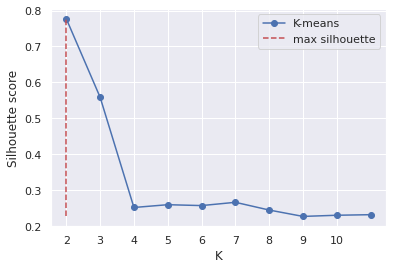

In [28]:
sil_score_1 = []
for m in models_1:
    sil_score_1.append(silhouette_score(ones[NUMERICAL_FEATURES], m.labels_))
    
plt.plot(CLUSTERS, sil_score_1, 'bo-', label="K-means")
plt.vlines(np.argmax(sil_score_1) + 2, min(sil_score_1), max(sil_score_1), 'r', '--', label="max silhouette")
plt.xticks(CLUSTERS)
plt.xlabel("K")
plt.xticks(range(2, 11))
plt.ylabel("Silhouette score")
plt.legend()
plt.show()

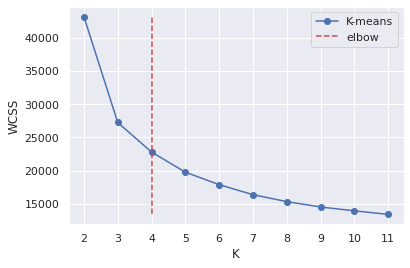

In [29]:
kl = KneeLocator(CLUSTERS, wcss_1, curve="convex", direction="decreasing")
plt.plot(CLUSTERS, wcss_1, 'o-', label="K-means")
plt.vlines(kl.elbow, min(wcss_1), max(wcss_1), 'r', '--', label="elbow")
plt.xticks(CLUSTERS)
plt.xlabel("K")
plt.ylabel("WCSS")
plt.legend()
plt.show()

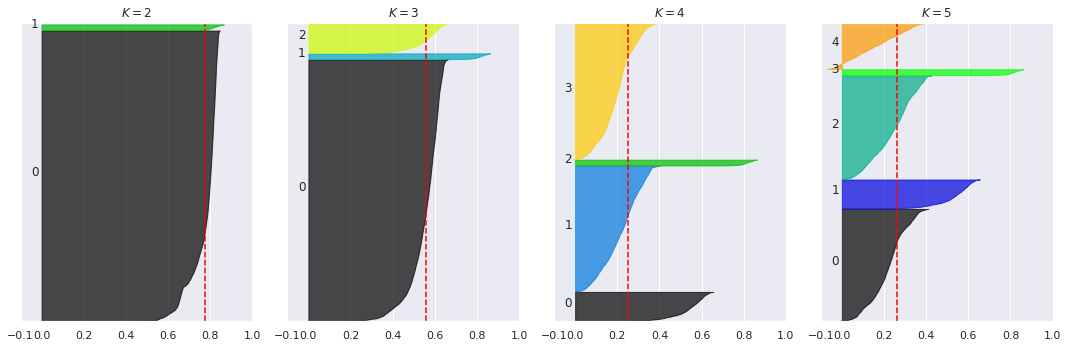

In [30]:
plot_silouette(ones[NUMERICAL_FEATURES], models_1[:4])

Pick $k=4$

In [31]:
kmeans_1 = models_1[2]
print(kmeans_1)

KMeans(n_clusters=4, n_init=20, random_state=123)


In [32]:
clusters_1 = kmeans_1.predict(ones[NUMERICAL_FEATURES])

ones['Cluster'] = clusters_1

ones

,Age,Fnlwgt,Education-num,Capital-gain,Capital-loss,Hours-per-week,Target,Cluster
7,1.032523,0.187844,-0.440434,-0.147502,-0.218673,0.339381,1,1
8,-0.566720,-1.363035,1.521353,1.753432,-0.218673,0.756794,1,3
9,0.270979,-0.287213,1.128996,0.551379,-0.218673,-0.078031,1,3
10,-0.109793,0.858146,-0.048076,-0.147502,-0.218673,3.261270,1,1
11,-0.642875,-0.459014,1.128996,-0.147502,-0.218673,-0.078031,1,3
...,...,...,...,...,...,...,...,...
32538,-0.033639,-0.479051,1.128996,1.879765,-0.218673,0.339381,1,3
32545,0.042516,-0.741041,0.736639,-0.147502,-0.218673,-1.747682,1,3
32554,1.108678,1.249989,1.521353,-0.147502,-0.218673,-0.078031,1,3
32557,0.118670,-0.335246,-0.440434,-0.147502,-0.218673,-0.078031,1,1


In [33]:
ones['Cluster'].value_counts()

3    3439
1    3184
0     735
2     148
Name: Cluster, dtype: int64

# Test, Training, Validation splitting

In [34]:
from sklearn.model_selection import train_test_split

In [35]:
train_test_0, validation_0 = train_test_split(zeroes, train_size=0.8, stratify=zeroes['Cluster'])
train_0, test_0 = train_test_split(train_test_0, train_size=0.7, stratify=train_test_0['Cluster'])

train_test_1, validation_1 = train_test_split(ones, train_size=0.8, stratify=ones['Cluster'])
train_1, test_1 = train_test_split(train_test_1, train_size=0.7, stratify=train_test_1['Cluster'])

In [36]:
df_names = ["train_0", "test_0", "validation_0", "train_1", "test_1", "validation_1"]
for i,set_ in enumerate([train_0, test_0, validation_0, train_1, test_1, validation_1]):
    df_name = df_names[i]
    set_.to_csv(df_name)

In [37]:
# the validation set is (roughly) the 20% of the total dataset
assert abs(len(validation_0) + len(validation_1) - 0.2*len(df)) < 5
# the train set is (roughly) the 80% of the remaining dataset
assert abs(len(train_1) + len(train_0)-0.7*(len(df) - 0.2 * len(df))) < 5

In [38]:
# check that each set has roughly the same distribution of clusters
print(zeroes['Cluster'].value_counts(normalize=True))
print(train_test_0['Cluster'].value_counts(normalize=True))
print(train_0['Cluster'].value_counts(normalize=True))
print(test_0['Cluster'].value_counts(normalize=True))
print(validation_0['Cluster'].value_counts(normalize=True))

0    0.325763
1    0.265851
2    0.223523
3    0.155790
4    0.029073
Name: Cluster, dtype: float64
0    0.325748
1    0.265879
2    0.223517
3    0.155805
4    0.029051
Name: Cluster, dtype: float64
0    0.325706
1    0.265899
2    0.223528
3    0.155831
4    0.029036
Name: Cluster, dtype: float64
0    0.325847
1    0.265832
2    0.223490
3    0.155744
4    0.029087
Name: Cluster, dtype: float64
0    0.325823
1    0.265739
2    0.223548
3    0.155732
4    0.029158
Name: Cluster, dtype: float64


In [39]:
# check that each set has roughly the same distribution of clusters
print(ones['Cluster'].value_counts(normalize=True))
print(train_test_1['Cluster'].value_counts(normalize=True))
print(train_1['Cluster'].value_counts(normalize=True))
print(test_1['Cluster'].value_counts(normalize=True))
print(validation_1['Cluster'].value_counts(normalize=True))

3    0.458167
1    0.424194
0    0.097922
2    0.019718
Name: Cluster, dtype: float64
3    0.458195
1    0.424217
0    0.097935
2    0.019654
Name: Cluster, dtype: float64
3    0.458115
1    0.424322
0    0.097811
2    0.019752
Name: Cluster, dtype: float64
3    0.458380
1    0.423973
0    0.098224
2    0.019423
Name: Cluster, dtype: float64
3    0.458056
1    0.424101
0    0.097870
2    0.019973
Name: Cluster, dtype: float64


In [40]:
train_set = df.loc[train_0.index.append(train_1.index)]
test_set = df.loc[test_0.index.append(test_1.index)]
validation_set = df.loc[validation_0.index.append(validation_1.index)]

In [41]:
train_set

,Age,Workclass,Fnlwgt,Education,Education-num,Marital-status,Occupation,Relationship,Race,Sex,Capital-gain,Capital-loss,Hours-per-week,Native-country,Target
7662,40,0.285829,95226,0.421658,13,0.048399,0.485342,0.106689,0.263855,0.313955,0,0,50,0.254411,0
17310,32,0.218918,398019,0.062950,4,0.048399,0.007092,0.106689,0.263855,0.113783,0,0,15,0.054455,0
7445,34,0.218918,170772,0.164328,9,0.455011,0.225590,0.455728,0.263855,0.313955,0,0,50,0.254411,0
7152,24,0.218918,33016,0.200180,10,0.048399,0.225590,0.014343,0.263855,0.313955,0,0,40,0.254411,0
6506,25,0.218918,315643,0.164328,9,0.455011,0.041134,0.455728,0.263855,0.313955,0,0,30,0.254411,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6010,35,0.218918,189916,0.421658,13,0.455011,0.270647,0.493599,0.263855,0.113783,0,0,30,0.254411,1
24384,51,0.218918,230858,0.200180,10,0.455011,0.225590,0.455728,0.263855,0.313955,0,1977,60,0.254411,1
10776,54,0.558659,146574,0.164328,9,0.455011,0.225590,0.455728,0.263855,0.313955,0,0,40,0.254411,1
3612,52,0.387063,617021,0.421658,13,0.455011,0.305159,0.455728,0.129972,0.313955,7688,0,40,0.254411,1


In [42]:
#add clusters to train, test and valid. sets
clus_tr = pd.concat([train_0['Cluster'], train_1['Cluster']])
train_set['Cluster'] = clus_tr

clus_te = pd.concat([test_0['Cluster'], test_1['Cluster']])
test_set['Cluster'] = clus_te

clus_val = pd.concat([validation_0['Cluster'], validation_1['Cluster']])
validation_set['Cluster'] = clus_val

In [43]:
train_set['Target'].value_counts(normalize=True)

0    0.751007
1    0.248993
Name: Target, dtype: float64

In [44]:
test_set['Target'].value_counts(normalize=True)

0    0.750899
1    0.249101
Name: Target, dtype: float64

In [45]:
validation_set['Target'].value_counts(normalize=True)

0    0.750871
1    0.249129
Name: Target, dtype: float64

# Encoding

In [46]:
train_set[NUMERICAL_FEATURES] = scaler.transform(train_set[NUMERICAL_FEATURES])
test_set[NUMERICAL_FEATURES] = scaler.transform(test_set[NUMERICAL_FEATURES])
validation_set[NUMERICAL_FEATURES] = scaler.transform(validation_set[NUMERICAL_FEATURES])

# Saving the datasets

In [47]:
test_set.to_csv("adult_testset.csv")
train_set.to_csv("adult_trainset.csv")
validation_set.to_csv("adult_validationset.csv")

# Random Forest Creation

This script has been run on the server, here just for backup.

# Load the random forest

In [48]:
df

,Age,Workclass,Fnlwgt,Education,Education-num,Marital-status,Occupation,Relationship,Race,Sex,Capital-gain,Capital-loss,Hours-per-week,Native-country,Target
0,39,0.268960,77516,0.421658,13,0.048399,0.133907,0.106689,0.263855,0.313955,2174,0,40,0.254411,0
1,50,0.285829,83311,0.421658,13,0.455011,0.485342,0.455728,0.263855,0.313955,0,0,13,0.254411,0
2,38,0.218918,215646,0.164328,9,0.107312,0.061527,0.106689,0.263855,0.313955,0,0,40,0.254411,0
3,53,0.218918,234721,0.056298,7,0.455011,0.061527,0.455728,0.129972,0.313955,0,0,40,0.254411,0
4,28,0.218918,338409,0.421658,13,0.455011,0.448686,0.493599,0.129972,0.113783,0,0,40,0.271739,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,0.218918,257302,0.253968,12,0.455011,0.305159,0.493599,0.263855,0.113783,0,0,38,0.254411,0
32557,40,0.218918,154374,0.164328,9,0.455011,0.124236,0.455728,0.263855,0.313955,0,0,40,0.254411,1
32558,58,0.218918,151910,0.164328,9,0.096735,0.133907,0.066334,0.263855,0.113783,0,0,40,0.254411,0
32559,22,0.218918,201490,0.164328,9,0.048399,0.133907,0.014343,0.263855,0.313955,0,0,20,0.254411,0


In [49]:
df.loc[0]

Age                  39.000000
Workclass             0.268960
Fnlwgt            77516.000000
Education             0.421658
Education-num        13.000000
Marital-status        0.048399
Occupation            0.133907
Relationship          0.106689
Race                  0.263855
Sex                   0.313955
Capital-gain       2174.000000
Capital-loss          0.000000
Hours-per-week       40.000000
Native-country        0.254411
Target                0.000000
Name: 0, dtype: float64